## Val test

In [1]:
import numpy as np
import torch

from models import MPS, ComplexTensor
from utils import build_ghz_plus
from qtools import pauli_exp
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from utils import MeasurementDataset, select_hyperparams_and_train

import matplotlib.pyplot as plt
import datetime
from utils import make_linear_schedule, make_exp_schedule

Loaded libmkl_rt.so for dgesvd


Pick system size, dimensionality of local hilbert space, and initial bond dim

In [2]:
L=12
local_dim=2
bond_dim=2

In [3]:
# dev = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
dev = torch.device("cpu")

Initialize the MPS model

In [4]:
psi = MPS(L=L, local_dim=local_dim, bond_dim=bond_dim)

In [5]:
psi.to(device=dev)

The ground truth state (a ghz state with no phase)

In [6]:
ghz_plus = build_ghz_plus(L)
ghz_plus.to(device=dev)

Samples_tr: lists indices of the observed basis states at each measurement. 0 = spin up, 1 = spin down

settings: array of corresponding angles

In [7]:
# fname_settings = "test_datasets/settings_ghz_plus_random_basis_L=%d.npy"%L
# fname_samples = "test_datasets/samples_ghz_plus_random_basis_L=%d.npy"%L
fname_settings = "datasets/mps_sampled/ghz_plus_L=%d_angles.npy"%L
fname_samples = "datasets/mps_sampled/ghz_plus_L=%d_outcomes.npy"%L
Nsamp=20000
samples = np.load(fname_samples)[:Nsamp]
samples_tr = torch.tensor((1-samples)/2).to(dtype=torch.long,device=dev)
settings = np.load(fname_settings)[:Nsamp]

In [8]:
theta = torch.tensor(settings[...,0],dtype=torch.float32,device=dev)
phi = torch.tensor(settings[...,1],dtype=torch.float32,device=dev)

Holds the unitaries corresponding to each angle

In [9]:
U = pauli_exp(theta, phi)


In [10]:
ds = MeasurementDataset(samples=samples_tr,rotations=U)


In [11]:
batch_size = 1028

Number of epochs of training

In [12]:
epochs = 50

Max number of singular values to keep, and cutoff below which to truncate singular values

In [13]:
max_sv_to_keep = 10
cutoff=1e-4

In [14]:
val_split=.1
Nparam=30

In [15]:
model, logdict, params, trloss, valloss = select_hyperparams_and_train(ds,batch_size, epochs, 
                                                                        val_split=val_split, Nparam=Nparam,
                                                                      cutoff=cutoff,max_sv_to_keep=max_sv_to_keep,
                                                                ground_truth_mps=ghz_plus,use_cache=True,
                                                                    record_s2=True,early_stopping=True,
                                                                      compute_overlaps=True,verbose=True)

Training on 30 different param sets, with 1 seeds each
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69d7b8>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b0598>
Acheived val score: 6.742805004119873
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69d598>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b0620>
Acheived val score: 8.341462135314941
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69d620>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b06a8>
Acheived val score: 10.582881927490234
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69d840>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b0730>
Acheived val score: 10.216889381408691
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69d8c8>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b07b8>
Error during factorization: 3
Training failed


/home/brian/Code/mps-gm/models.py:71: RuntimeWarning: invalid value encountered in multiply
  return self.real.detach().cpu().numpy() + 1j * self.imag.detach().cpu().numpy()
/home/brian/Code/mps-gm/models.py:735: RuntimeWarning: invalid value encountered in multiply
  return 2 * self.partial_deriv_twosite_renyi2_entropy(site_index).numpy().conj()


Acheived val score: 6.792758941650391
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69db70>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b0a60>
Acheived val score: 10.493452072143555
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69dbf8>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b0ae8>
Acheived val score: 10.481751441955566
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69dc80>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b0b70>
Acheived val score: 7.426151275634766
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69dd08>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b0bf8>
Acheived val score: 10.034744262695312
Training with lr = <function make_exp_schedule.<locals>.f at 0x7f7a7b69dd90>, s2 penalty = <function make_exp_schedule.<locals>.f at 0x7f7a7b6b0c80>
Acheived val score: 6.708547592163086
Training with lr = <func

/home/brian/Code/mps-gm/utils.py:659: UserWarning: overlap estimate failed to converge within tolerance 1.00e-02
  warnings.warn("overlap estimate failed to converge within tolerance {0:.2e}".format(eps))


Finished epoch 11 in 16.167 sec
Model shape:  [(1, 2), (2, 4), (4, 8), (8, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 8), (8, 4), (4, 2), (2, 1)]
Finished epoch 12 in 7.685 sec
Model shape:  [(1, 2), (2, 4), (4, 8), (8, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 8), (8, 4), (4, 2), (2, 1)]
Finished epoch 13 in 9.072 sec
Model shape:  [(1, 2), (2, 4), (4, 8), (8, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 8), (8, 4), (4, 2), (2, 1)]
Finished epoch 14 in 7.678 sec
Model shape:  [(1, 2), (2, 4), (4, 8), (8, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 8), (8, 4), (4, 2), (2, 1)]
Finished epoch 15 in 9.121 sec
Model shape:  [(1, 2), (2, 4), (4, 8), (8, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 8), (8, 4), (4, 2), (2, 1)]
Finished epoch 16 in 7.702 sec
Model shape:  [(1, 2), (2, 4), (4, 8), (8, 10), (10, 10), (10, 10), (10, 10), (10, 10), (10, 8), (8, 4), (4, 2), (2, 1)]
Finished epoch 17 in 10.296 sec
Model shape:  [(1, 2), (2, 4), (4, 8), (8, 10), (10, 10

In [16]:
params

{'lr_scale': 0.04644644925723403,
 'lr_timescale': 8.884439633331684,
 's2_scale': 0.915956859240334,
 's2_timescale': 14.845337896329106}

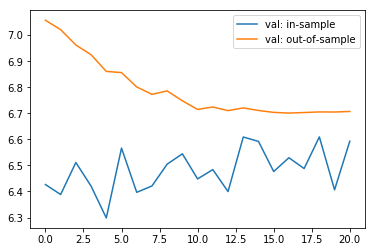

In [17]:
fig, ax = plt.subplots()
plt.plot(trloss, label="val: in-sample")
plt.plot(valloss, label="val: out-of-sample")
plt.legend()

In [18]:
loss = logdict['loss']
eps=len(loss)
fidelity_mps = logdict['fidelity_mps']
overlap = logdict['overlap']

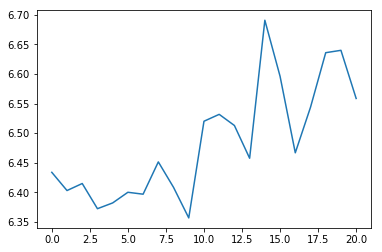

In [19]:
fig, ax = plt.subplots()
plt.plot(loss)

<Container object of 3 artists>

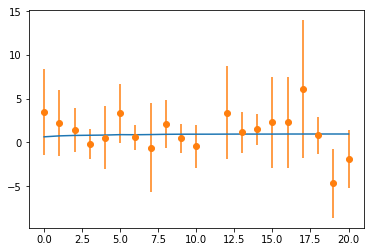

In [24]:
fig, ax = plt.subplots()
plt.plot(np.arange(eps), fidelity_mps**2, label='mps')
is_conv = overlap['converged']
plt.errorbar(np.arange(eps)[is_conv], overlap['mean'][is_conv],
                            yerr=overlap['err'][is_conv],
                            linestyle='none', marker='o', label="data overlap")

In [21]:
model.shape

[(1, 2),
 (2, 4),
 (4, 8),
 (8, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 10),
 (10, 8),
 (8, 4),
 (4, 2),
 (2, 1)]

In [22]:
params

{'lr_scale': 0.04644644925723403,
 'lr_timescale': 8.884439633331684,
 's2_scale': 0.915956859240334,
 's2_timescale': 14.845337896329106}